In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import itertools

from sqlalchemy import create_engine
import requests
from bs4 import BeautifulSoup

import calendar
from datetime import datetime, date, timedelta

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from textblob import TextBlob, Word
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Connecting to storms Database With SQLalchemy
engine_local = create_engine('postgresql://localhost:5432/storms')

In [5]:
# Displaying the first 3 rows from the tornado table
sql_query = 'SELECT * FROM tornadoes_1950_mid2017 LIMIT 3' 
pd.read_sql(sql_query, engine_local)

BEGIN_YEARMONTH  BEGIN_DAY  BEGIN_TIME  END_YEARMONTH  END_DAY  END_TIME  \
0           195004         28        1445         195004       28      1445   
1           195004         29        1530         195004       29      1530   
2           195007          5        1800         195007        5      1800   

  EPISODE_ID  EVENT_ID         STATE  STATE_FIPS     ...      END_RANGE  \
0       None  10096222      OKLAHOMA        40.0     ...            0.0   
1       None  10120412         TEXAS        48.0     ...            0.0   
2       None  10104927  PENNSYLVANIA        42.0     ...            0.0   

  END_AZIMUTH END_LOCATION BEGIN_LAT  BEGIN_LON END_LAT END_LON  \
0        None         None     35.12      -99.2   35.17  -99.20   
1        None         None     31.90      -98.6   31.73  -98.60   
2        None         None     40.58      -75.7   40.65  -75.47   

  EPISODE_NARRATIVE EVENT_NARRATIVE DATA_SOURCE  
0              None            None         PUB  
1              None            None         PUB  
2              None            None         PUB  

[3 rows x 51 columns]

In [6]:
sql_query = """
SELECT COUNT("TOR_F_SCALE"), "TOR_F_SCALE"
FROM tornadoes_1950_mid2017 
WHERE "BEGIN_YEARMONTH" >= 200701
GROUP BY "TOR_F_SCALE"
ORDER BY count DESC
"""
pd.read_sql(sql_query, engine_local)

count TOR_F_SCALE
0   8617         EF0
1   5474         EF1
2   1584         EF2
3    445         EF3
4    116         EFU
5    103         EF4
6     14         EF5
7     11          F1
8      8          F0
9      3          F2

In [7]:
#editing data for values post 2007, when the  Fujita scale  started being recorded, although it's been around since 1970's :p
sql_query = """
SELECT COUNT("TOR_F_SCALE"), "TOR_F_SCALE"
FROM tornadoes_1950_mid2017 
WHERE "BEGIN_YEARMONTH" >= 200702
GROUP BY "TOR_F_SCALE"
ORDER BY count DESC
"""
pd.read_sql(sql_query, engine_local)

count TOR_F_SCALE
0   8617         EF0
1   5474         EF1
2   1584         EF2
3    445         EF3
4    116         EFU
5    103         EF4
6     14         EF5

In [8]:
# Saving new dataset):
sql_query = """
SELECT * 
FROM tornadoes_1950_mid2017 
WHERE "BEGIN_YEARMONTH" >= 200702;
"""

raw_2007_2017 = pd.read_sql(sql_query, engine_local)

# Counting the number of tornadoes in each magnitude category:
raw_2007_2017.TOR_F_SCALE.value_counts()

EF0    8617
EF1    5474
EF2    1584
EF3     445
EFU     116
EF4     103
EF5      14
Name: TOR_F_SCALE, dtype: int64

In [8]:
raw_2007_2017.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16353 entries, 0 to 16352
Data columns (total 51 columns):
BEGIN_YEARMONTH       16353 non-null int64
BEGIN_DAY             16353 non-null int64
BEGIN_TIME            16353 non-null int64
END_YEARMONTH         16353 non-null int64
END_DAY               16353 non-null int64
END_TIME              16353 non-null int64
EPISODE_ID            16353 non-null float64
EVENT_ID              16353 non-null int64
STATE                 16353 non-null object
STATE_FIPS            16353 non-null float64
YEAR                  16353 non-null int64
MONTH_NAME            16353 non-null object
EVENT_TYPE            16353 non-null object
CZ_TYPE               16353 non-null object
CZ_FIPS               16353 non-null int64
CZ_NAME               16353 non-null object
WFO                   16353 non-null object
BEGIN_DATE_TIME       16353 non-null object
CZ_TIMEZONE           16353 non-null object
END_DATE_TIME         16353 non-null object
INJURIES_DIRECT   

In [9]:
tornado_2007_2017 = raw_2007_2017.copy()
tornado_2007_2017.columns

Index(['BEGIN_YEARMONTH', 'BEGIN_DAY', 'BEGIN_TIME', 'END_YEARMONTH',
       'END_DAY', 'END_TIME', 'EPISODE_ID', 'EVENT_ID', 'STATE', 'STATE_FIPS',
       'YEAR', 'MONTH_NAME', 'EVENT_TYPE', 'CZ_TYPE', 'CZ_FIPS', 'CZ_NAME',
       'WFO', 'BEGIN_DATE_TIME', 'CZ_TIMEZONE', 'END_DATE_TIME',
       'INJURIES_DIRECT', 'INJURIES_INDIRECT', 'DEATHS_DIRECT',
       'DEATHS_INDIRECT', 'DAMAGE_PROPERTY', 'DAMAGE_CROPS', 'SOURCE',
       'MAGNITUDE', 'MAGNITUDE_TYPE', 'FLOOD_CAUSE', 'CATEGORY', 'TOR_F_SCALE',
       'TOR_LENGTH', 'TOR_WIDTH', 'TOR_OTHER_WFO', 'TOR_OTHER_CZ_STATE',
       'TOR_OTHER_CZ_FIPS', 'TOR_OTHER_CZ_NAME', 'BEGIN_RANGE',
       'BEGIN_AZIMUTH', 'BEGIN_LOCATION', 'END_RANGE', 'END_AZIMUTH',
       'END_LOCATION', 'BEGIN_LAT', 'BEGIN_LON', 'END_LAT', 'END_LON',
       'EPISODE_NARRATIVE', 'EVENT_NARRATIVE', 'DATA_SOURCE'],
      dtype='object')

In [10]:
# Transforming the function in part 1 into an easier-to-read dictionnary
# For each compass direction corresponds a clockwise angle in degrees from North
# This dictionnary will be used to convert the azimuths variables from the tornado dataframe
compassdir2degrees = {'N': 0., 'NNE': 22.5, 'NE': 45., 'ENE': 67.5, 'E': 90., 'ESE': 112.5, 
                      'SE': 135., 'SSE': 157.5, 'S': 180., 'SSW': 202.5, 'SW': 225., 
                      'WSW': 247.5, 'W': 270., 'WNW': 292.5, 'NW': 315., 'NNW': 337.5}


def compute_Az_AvLat_AvLon_fromLatLong(df, xA='BEGIN_LON', yA='BEGIN_LAT', xB='END_LON',
                                       yB='END_LAT', outMeanLat='Mean_Lat', 
                                       outMeanLon='Mean_Lon', outAz='Azimuth'):
    '''Takes a tornado dataframe in input, with geographical coordinates of beginning and end 
    points.
    Returns the dataframe with 3 new features: 
    direction the tornado headed from North (azimuth of its rectiligne path)
    average latitude
    average longitude'''
    
    # New features with average latitude and longitude of the tornado path:
    LAT = (df[yA]+df[yB])/2
    LON = (df[xA]+df[xB])/2
    df[outMeanLat] = np.round(LAT,4)
    df[outMeanLon] = np.round(LON,4)

    # Approximate Earth radius in miles:
    R = 3959
    
    # Coordinates differences converted to radians:
    diffLON = np.radians(df[xB] - df[xA])
    diffLAT = np.radians(df[yB] - df[yA])
      
    # Azimuth computed from trigonometry (arctan2 allows getting the angle in range (-pi,pi) 
    # instead of (-pi/2,pi/2) like with conventional arctan):
    AZ = pd.Series(index=diffLON.index)
    for i in range(len(diffLON)):
        if diffLAT[i]==0 and diffLON[i]==0:
            AZ[i] = np.nan
        else:
            AZ[i] = np.degrees(np.arctan2(diffLON[i],diffLAT[i]))
    
    # Saving azimuth into new column:
    df[outAz] = np.round(AZ,2)

    # Let's make the North as the middle of the range => angles from ]-pi;pi] instead of [0;2pi[
    df[outAz] = df[outAz].map(lambda x: x-360 if x>180 else x)

    return df


In [11]:
#converting to Integers 
def convertEFtonb(x):
    '''Converts an EF scale string to integer of the corresponding number'''
    if x=='EF0' or x=='EFU': return 0
    elif x=='EF1': return 1
    elif x=='EF2': return 2
    elif x=='EF3': return 3
    elif x=='EF4': return 4
    elif x=='EF5': return 5
    else: return np.nan

In [12]:
#Creating a Windrose Graph - to hightlight direction of Tornadoe 

def plot_windrose(df, EFscale='TOR_F_SCALE', Azimuth='Azimuth', TorYears='2007-2017'):
    '''Plots a windrose diagram from the azimuth and EF scales of a tornado dataframe'''
    
    # Somehow, the packages seems to unload sometimes, when imported upfront. 
    # The solution I found was to import them each time the function is called.
    from windrose import WindroseAxes, plot_windrose
    
    dfwindroseAzim = pd.DataFrame({'speed':list(df[EFscale].map(convertEFtonb).values), 
                                   'direction':list(df[Azimuth].values)}).reset_index(drop=True)

    # Radial grids must be positive for the windrose display:
    dfwindroseAzim.direction = dfwindroseAzim.direction.map(lambda x: 0.001 if x==0 
                                                            else 360+x if x<0 else x)

    sns.set(font_scale=1.3)
    plot_windrose(dfwindroseAzim, kind='bar', bins=np.arange(-0.5,5.5,1), edgecolor='black')

    plt.title("Distribution of the {} tornadoes' heading (Blue to Red for weak to strong\
              magnitudes)".format(TorYears))
    plt.legend("lower right")
    plt.show()

In [13]:
#Transforming Date & time from Dataset
def computeduration(df, beginDT='BEGIN_DATE_TIME', endDT='END_DATE_TIME'):
    '''Takes a tornado dataframe in input, with dates and times of beginning and end of a tornado,
    in text format.
    Converts them into datatime format.
    Computes the duration in minutes and returns it as new column
    Computes the average date and average time, 
    Computes the day of the year, and time in floating format, and returns them as new columns'''

    # Changing to datetime format:
    df[beginDT] = pd.to_datetime(df[beginDT])
    df[endDT] = pd.to_datetime(df[endDT])
    
    # Computes the duration:
    df['Duration'] =  df[endDT] - df[beginDT]
    # Converting to minutes from seconds:
    df['Duration'] = df.Duration.map(lambda x: int(round(x.total_seconds()/60.)))
    
    # Computing the average date and time of a tornado event:
    df['AverageDate'] = pd.to_datetime(df[beginDT] + (df[endDT] - df[beginDT])/2)
    df['AverageTime'] = df['AverageDate']
    
    def dayoftheyear(x):
        '''converts a timestamp object into day of the year, taking leap years into account'''
        dayYear = x.timetuple().tm_yday
        # Feb 28 corresponds to year day 31+28=59
        if calendar.isleap(x.year) and dayYear<=59:
            return dayYear
        # For dates superior or equal to Feb 29, for leap years, returns the value-1 for a number
        # to always correspond to the same date for any year
        elif calendar.isleap(x.year) and dayYear>59:
            return dayYear - 1
        # For non leap years:
        else:
            return dayYear
    # Converting date to day of the year:
    df['AverageDate'] = df['AverageDate'].map(dayoftheyear)
    
    # Converting time to float from Timestamp object:
    df['AverageTime'] = df['AverageTime'].map(lambda x: x.time())
    df['AverageTime'] = df['AverageTime'].map(lambda x: x.hour) \
    + df['AverageTime'].map(lambda x: round((x.minute*100/60.)/100., 2)) \
    + df['AverageTime'].map(lambda x: round((x.second*100/60.)/10000., 4))
    
    return df

In [14]:
testdf = raw_2007_2017[['BEGIN_DATE_TIME', 'END_DATE_TIME']].head()

computeduration(testdf)

BEGIN_DATE_TIME       END_DATE_TIME  Duration  AverageDate  AverageTime
0 2007-05-06 15:40:00 2007-05-06 15:43:00         3          126       15.685
1 2007-07-02 17:30:00 2007-07-02 17:35:00         5          183       17.535
2 2007-04-21 18:48:00 2007-04-21 18:57:00         9          111       18.875
3 2007-06-01 11:55:00 2007-06-01 11:56:00         1          152       11.925
4 2007-04-15 06:15:00 2007-04-15 06:15:00         0          105        6.250

In [15]:
def convertcost_tointeger(cost):
    '''From a cost in text format in format 'nb'.00'letter' where letter = K or M or B
    Returns a cost as integer'''
    if pd.isnull(cost): return 0
    elif 'K' in cost: return int(round(float(cost[:-2]) * 10**3))
    elif 'M' in cost: return int(round(float(cost[:-2]) * 10**6))
    elif 'B' in cost: return int(round(float(cost[:-2]) * 10**9))
    else: return np.nan

In [16]:
# Testing the previous function with a small subset of data:
testdf2 = raw_2007_2017[['DAMAGE_PROPERTY', 'DAMAGE_CROPS']][67:74]

testdf2['PropertyDamageCost'] = testdf2.DAMAGE_PROPERTY.map(convertcost_tointeger)
testdf2['CropsDamageCost'] = testdf2.DAMAGE_CROPS.map(convertcost_tointeger)
testdf2


DAMAGE_PROPERTY DAMAGE_CROPS  PropertyDamageCost  CropsDamageCost
67           1.50M        0.00K             1500000                0
68         100.00K        0.00K              100000                0
69           3.50M         None             3500000                0
70          20.00K        0.00K               20000                0
71           0.00K        0.00K                   0                0
72           0.00K        0.00K                   0                0
73           8.00K        0.00K                8000                0

In [17]:
raw_2007_2017['STATE_FIPS'].unique()

array([20., 12., 46., 28., 39., 45., 18., 38., 27., 31., 19., 48.,  1.,
        6., 22.,  5., 26., 35., 17., 29., 40., 24.,  8., 21., 47., 55.,
       42., 16., 37., 13., 30., 41., 56., 49., 25., 51.,  9., 54., 36.,
       23., 99., 15.,  4., 53., 33., 50., 44., 32., 34., 10., 11.])

In [18]:
raw_2007_2017[raw_2007_2017['STATE_FIPS']==99][['STATE_FIPS','STATE']].head(10)

STATE_FIPS        STATE
1165         99.0  PUERTO RICO
4343         99.0  PUERTO RICO
7630         99.0  PUERTO RICO
8940         99.0  PUERTO RICO
9968         99.0  PUERTO RICO
13454        99.0  PUERTO RICO
13675        99.0  PUERTO RICO

In [19]:
# Link to the FIPS table:
link = "https://en.wikipedia.org/wiki/Federal_Information_Processing_Standard_state_code"
response = requests.get(link)
html = response.text

# Making a soup out of the html and creating the list of FIPS table rows:
soup = BeautifulSoup(html, "lxml")
listofFIPSrows = soup.findAll("tr")
    
# Creating a dictionary with the correspondances between state FIPS number and 
# state name abbreviation (eg: 'AL' for 1, 'AK' for 2, etc.):
fips_to_state = {}
for element in listofFIPSrows[1:75]:
    # Some FIPS numbers in the table do not have associated abbreviation, we therefore
    # do not use those rows:
    if str(element).split('<td>')[2][:2] != '</':
        fips_to_state[int(str(element).split('<td>')[3][:2])] = str(element).split('<td>')[2][:2]

# Puerto Rico is registered as number 99 in the tornado data:
fips_to_state[99] = 'PR'

print("FIPS number and state abreviation dictionary:\n"), fips_to_state

FIPS number and state abreviation dictionary:



(None,
 {1: 'AL',
  2: 'AK',
  60: 'AS',
  4: 'AZ',
  5: 'AR',
  6: 'CA',
  8: 'CO',
  9: 'CT',
  10: 'DE',
  11: 'DC',
  12: 'FL',
  64: 'FM',
  13: 'GA',
  66: 'GU',
  15: 'HI',
  16: 'ID',
  17: 'IL',
  18: 'IN',
  19: 'IA',
  20: 'KS',
  21: 'KY',
  22: 'LA',
  23: 'ME',
  68: 'MH',
  24: 'MD',
  25: 'MA',
  26: 'MI',
  27: 'MN',
  28: 'MS',
  29: 'MO',
  30: 'MT',
  31: 'NE',
  32: 'NV',
  33: 'NH',
  34: 'NJ',
  35: 'NM',
  36: 'NY',
  37: 'NC',
  38: 'ND',
  69: 'MP',
  39: 'OH',
  40: 'OK',
  41: 'OR',
  70: 'PW',
  42: 'PA',
  72: 'PR',
  44: 'RI',
  45: 'SC',
  46: 'SD',
  47: 'TN',
  48: 'TX',
  74: 'UM',
  49: 'UT',
  50: 'VT',
  51: 'VA',
  78: 'VI',
  53: 'WA',
  54: 'WV',
  55: 'WI',
  56: 'WY',
  99: 'PR'})

In [20]:
# Testing the previous dictionary application with a small subset of data:
testdf3 = raw_2007_2017[['STATE_FIPS','STATE']][784:790]

testdf3['State'] = testdf3['STATE_FIPS'].map(lambda x: fips_to_state[x])
testdf3

STATE_FIPS     STATE State
784        31.0  NEBRASKA    NE
785        20.0    KANSAS    KS
786        20.0    KANSAS    KS
787        48.0     TEXAS    TX
788        31.0  NEBRASKA    NE
789        20.0    KANSAS    KS

In [21]:
# Function to plot the confusion matrices in a nicer and more interpretable way:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues, 
                          xlab='Predicted magnitude', ylab='True magnitude'):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel(ylab)
    plt.xlabel(xlab)
    plt.show()

In [22]:
# Removing unnecessary columns:
tornado_2007_2017 = tornado_2007_2017.drop(['EVENT_ID', 'EPISODE_ID', 
                                            'EVENT_TYPE', 'MAGNITUDE', 'MAGNITUDE_TYPE', 
                                            'FLOOD_CAUSE', 
                                            'EPISODE_NARRATIVE', 'EVENT_NARRATIVE', 
                                            'DATA_SOURCE', 'CATEGORY'], axis=1)

# Adding 3 new columns with the duration and the average year-date and time: 
tornado_2007_2017 = computeduration(tornado_2007_2017)

# Removing original columns related to date and time:
tornado_2007_2017.drop(['BEGIN_YEARMONTH', 'BEGIN_DAY', 'BEGIN_TIME', 'END_YEARMONTH', 'END_DAY',
                        'END_TIME', 'BEGIN_DATE_TIME', 'CZ_TIMEZONE', 'END_DATE_TIME', 'YEAR',
                        'MONTH_NAME'], axis=1, inplace=True)

# Gathering direct and indirect deaths, and injuries:
tornado_2007_2017['Deaths'] = tornado_2007_2017.DEATHS_DIRECT + tornado_2007_2017.DEATHS_INDIRECT
tornado_2007_2017['Injuries'] = tornado_2007_2017.INJURIES_DIRECT +\
                                tornado_2007_2017.INJURIES_INDIRECT
tornado_2007_2017.drop(['DEATHS_DIRECT','DEATHS_INDIRECT','INJURIES_DIRECT','INJURIES_INDIRECT'],
                       axis=1, inplace=True)

# Adds 3 new columns average latitude, longitude and azimuth of tornado's path:
tornado_2007_2017 = compute_Az_AvLat_AvLon_fromLatLong(tornado_2007_2017)

Plot before imputing NaN azimuth values:


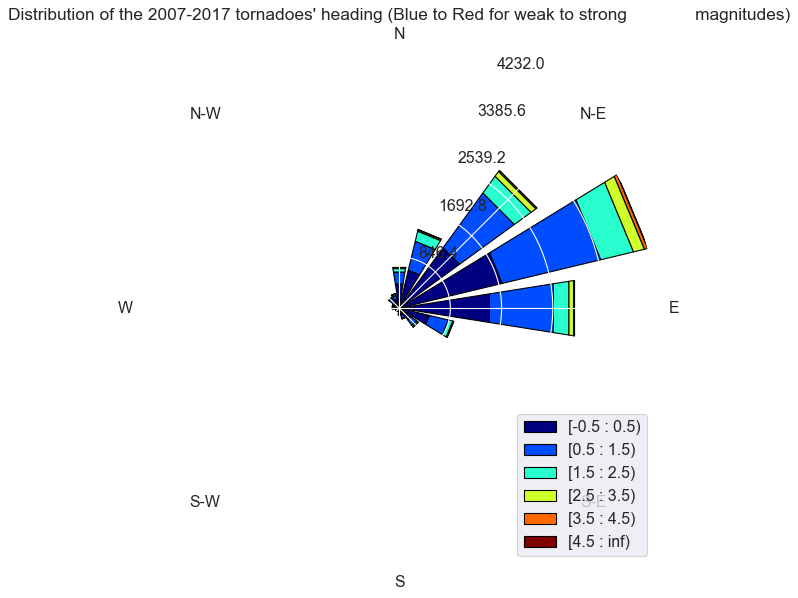

The median azimuth of the tornados' straight paths is:
We are replacing the computed NaN azimuths to this value.
nPlot after imputing NaN azimuth values:


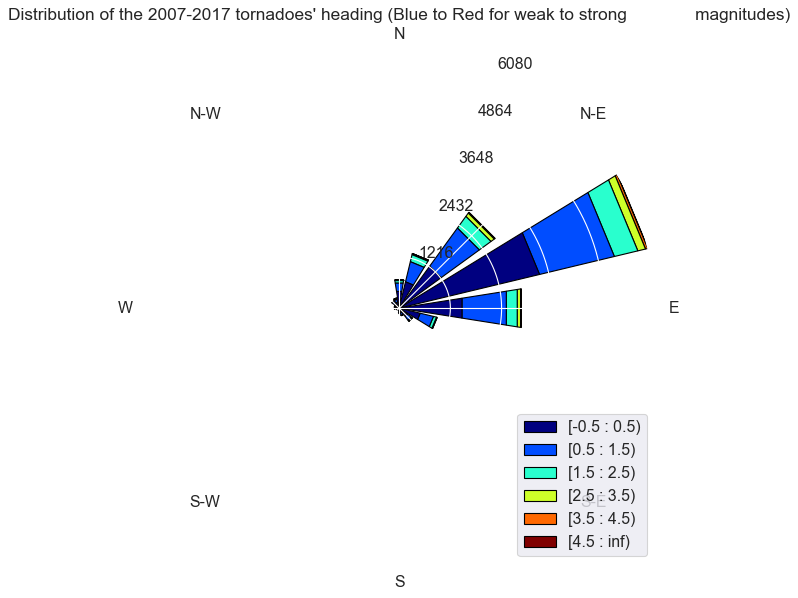

In [23]:
# Plots the windrose before imputing values for stationary tornadoes:
print("Plot before imputing NaN azimuth values:")
plot_windrose(tornado_2007_2017)

# Filling the azimuth NaN values with median:
print("The median azimuth of the tornados' straight paths is:"), \
      tornado_2007_2017['Azimuth'].median(), "degrees."
print("We are replacing the computed NaN azimuths to this value.")
tornado_2007_2017.Azimuth.fillna(tornado_2007_2017['Azimuth'].median(), inplace=True)

# Plots the windrose after imputing values for stationary tornadoes:
print("nPlot after imputing NaN azimuth values:")
plot_windrose(tornado_2007_2017)

# Converting the state FIPS numbers into state abbreviations easily recognizable:
tornado_2007_2017['State'] = tornado_2007_2017['STATE_FIPS'].map(lambda x: fips_to_state[x])

# Removing columns related to location:
tornado_2007_2017.drop(['BEGIN_RANGE', 'BEGIN_AZIMUTH', 'END_RANGE', 'END_AZIMUTH', 
                        'BEGIN_LAT', 'BEGIN_LON', 'END_LAT', 'END_LON', 
                        'CZ_NAME', 'CZ_TYPE', 'CZ_FIPS', 'WFO', 'STATE_FIPS', 'STATE', 
                        'BEGIN_LOCATION', 'END_LOCATION', 
                        'TOR_OTHER_CZ_STATE', 'TOR_OTHER_CZ_FIPS', 'TOR_OTHER_CZ_NAME',
                        'TOR_OTHER_WFO'],
                       axis=1, inplace=True)

# Converting the cost columns into integer numbers:
tornado_2007_2017['PropertyDamageCost'] = \
tornado_2007_2017.DAMAGE_PROPERTY.map(convertcost_tointeger)
tornado_2007_2017['CropsDamageCost'] = tornado_2007_2017.DAMAGE_CROPS.map(convertcost_tointeger)

# Removing old columns related to costs:
tornado_2007_2017.drop(['DAMAGE_PROPERTY', 'DAMAGE_CROPS'], axis=1, inplace=True)

# Replacing spaces by underscores in the SOURCE feature:
tornado_2007_2017.SOURCE = tornado_2007_2017.SOURCE.map(lambda x: x.replace(' ', '_'))

# Removing tornado with outlier TOR_LENGTH=100:
tornado_2007_2017 = tornado_2007_2017[tornado_2007_2017.TOR_LENGTH<50]



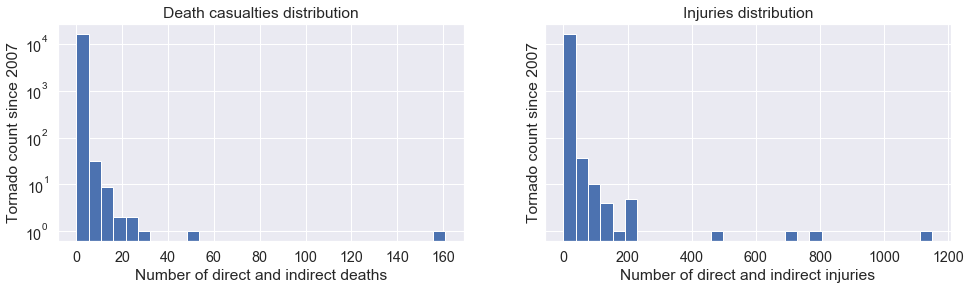

In [24]:
# Checking death casualties and injuries, taking both direct and indirect ones together:
fig, ax = plt.subplots(1,2, figsize=(16,4), sharey=True)
tornado_2007_2017.Deaths.hist(bins=30, log=True, ax=ax[0])
tornado_2007_2017.Injuries.hist(bins=30, log=True, ax=ax[1])
ax[0].set_title("Death casualties distribution")
ax[0].set_xlabel("Number of direct and indirect deaths")
ax[0].set_ylabel("Tornado count since 2007")
ax[1].set_title("Injuries distribution")
ax[1].set_xlabel("Number of direct and indirect injuries")
ax[1].set_ylabel("Tornado count since 2007")
plt.show()

In [29]:
y1 = tornado_2007_2017.reset_index().TOR_F_SCALE
X1 = tornado_2007_2017.reset_index().drop(['TOR_F_SCALE'], axis=1)

In [31]:
# Standardizing numerical features:
numfeat = ['TOR_LENGTH', 'TOR_WIDTH', 'Duration', 'AverageDate', 'AverageTime', 
           'Deaths', 'Injuries', 'Mean_Lat', 'Mean_Lon', 'Azimuth']
scaler = StandardScaler()
X1numfeat = pd.DataFrame(scaler.fit_transform(X1[numfeat]), columns=numfeat)
X1numfeat.head(2)

TOR_LENGTH  TOR_WIDTH  Duration  AverageDate  AverageTime    Deaths  \
0   -0.384696  -0.453753 -0.372725    -0.399389     0.034001 -0.046745   
1   -0.396503  -0.557985 -0.080881     0.326020     0.391832 -0.046745   

   Injuries  Mean_Lat  Mean_Lon   Azimuth  
0 -0.057794  0.025597 -0.818166 -1.299679  
1 -0.057794 -2.195896  1.453279 -1.324643

In [35]:
# Checking which State we will drop after dummification (the most common one should be dropped):
tornado_2007_2017.State.value_counts().head(2)

TX    1551
KS    1227
Name: State, dtype: int64

In [36]:
# Checking which Source we will drop after dummification (the most common one should be dropped):
tornado_2007_2017.SOURCE.value_counts().head(2)

NWS_Storm_Survey    10349
Trained_Spotter      1167
Name: SOURCE, dtype: int64

In [37]:
X1dums = pd.get_dummies(X1[['State','SOURCE']], prefix=['State','Source'],
                        columns=['State','SOURCE'])
X1dums.drop(['State_TX','Source_NWS_Storm_Survey'], axis=1, inplace=True)
X1dums.head(2)

State_AL  State_AR  State_AZ  State_CA  State_CO  State_CT  State_DC  \
0         0         0         0         0         0         0         0   
1         0         0         0         0         0         0         0   

   State_DE  State_FL  State_GA           ...            \
0         0         0         0           ...             
1         0         1         0           ...             

   Source_Official_NWS_Observations  Source_Other_Federal_Agency  \
0                                 0                            0   
1                                 0                            0   

   Source_Park/Forest_Service  Source_Public  Source_Social_Media  \
0                           0              0                    0   
1                           0              0                    0   

   Source_State_Official  Source_Storm_Chaser  Source_Trained_Spotter  \
0                      0                    0                       0   
1                      0                    0                       0   

   Source_Unknown  Source_Utility_Company  
0               0                       0  
1               0                       0  

[2 rows x 76 columns]

In [39]:
# Putting back together the standardized and dummifies features:
X1 = pd.concat([X1numfeat,X1dums], axis=1)
print(X1.shape, X1numfeat.shape, X1dums.shape)
X1.head(2)

(16353, 86) (16353, 10) (16353, 76)


TOR_LENGTH  TOR_WIDTH  Duration  AverageDate  AverageTime    Deaths  \
0   -0.384696  -0.453753 -0.372725    -0.399389     0.034001 -0.046745   
1   -0.396503  -0.557985 -0.080881     0.326020     0.391832 -0.046745   

   Injuries  Mean_Lat  Mean_Lon   Azimuth           ...            \
0 -0.057794  0.025597 -0.818166 -1.299679           ...             
1 -0.057794 -2.195896  1.453279 -1.324643           ...             

   Source_Official_NWS_Observations  Source_Other_Federal_Agency  \
0                                 0                            0   
1                                 0                            0   

   Source_Park/Forest_Service  Source_Public  Source_Social_Media  \
0                           0              0                    0   
1                           0              0                    0   

   Source_State_Official  Source_Storm_Chaser  Source_Trained_Spotter  \
0                      0                    0                       0   
1                      0                    0                       0   

   Source_Unknown  Source_Utility_Company  
0               0                       0  
1               0                       0  

[2 rows x 86 columns]

In [40]:
Xtrain1, Xtest1, ytrain1, ytest1 = train_test_split(X1, y1, test_size=0.3, 
                                                    stratify=y1, random_state=31)

In [41]:
ytest1.value_counts()

EF0    2585
EF1    1642
EF2     475
EF3     134
EFU      35
EF4      31
EF5       4
Name: TOR_F_SCALE, dtype: int64

In [46]:
ytest_valcounts = ytest1.value_counts()
accuracy_baseline = ytest_valcounts.get_values()[0]/float(ytest_valcounts.get_values().sum())
print("Accuracy | Test\t\t | Baseline\t\t | EF0 tornados:\t", round(accuracy_baseline, 3))

Accuracy | Test		 | Baseline		 | EF0 tornados:	 0.527


In [47]:
#LOGISTIC REGRESSION
lr1 = LogisticRegression()
accuracy_cv5_lr1 = np.mean(cross_val_score(lr1, Xtrain1, ytrain1, cv=5))
print("Accuracy | Train CV5\t | Logistic Regresssion\t | Default params:\t", round(accuracy_cv5_lr1, 3))

Accuracy | Train CV5	 | Logistic Regresssion	 | Default params:	 0.669


In [48]:
lr1.fit(Xtrain1, ytrain1)
yhat1_lr1 = lr1.predict(Xtest1)
accuracy_lr1 = accuracy_score(ytest1, yhat1_lr1)
print("Accuracy | Test\t\t | Logistic Regresssion\t | Default params:\t", round(accuracy_lr1, 3))

Accuracy | Test		 | Logistic Regresssion	 | Default params:	 0.671


In [49]:
#OPTIMIZATION
params_logreg_v1 = {'penalty': ['l1','l2'], 'C':np.logspace(2,6,5)}
lr2 = GridSearchCV(lr1, param_grid=params_logreg_v1, cv=5)
lr2.fit(Xtrain1, ytrain1)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'penalty': ['l1', 'l2'], 'C': array([1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [50]:
lr2.best_params_

{'C': 100.0, 'penalty': 'l1'}

In [51]:
print ("Accuracy | Train CV5\t | Logistic Regresssion\t | Optimal params:\t", round(lr2.best_score_, 3))

Accuracy | Train CV5	 | Logistic Regresssion	 | Optimal params:	 0.67


In [52]:
lr3 = lr2.best_estimator_.fit(Xtrain1, ytrain1)
yhat1_lr3 = lr3.predict(Xtest1)
accuracy_lr3 = accuracy_score(ytest1, yhat1_lr3)
print("Accuracy | Test\t\t | Logistic Regresssion\t | Optimal params:\t", round(accuracy_lr3, 3))

Accuracy | Test		 | Logistic Regresssion	 | Optimal params:	 0.671


In [55]:
#RANDOM FOREST 
rf1 = RandomForestClassifier(random_state=31)
accuracy_cv5_rf1 = np.mean(cross_val_score(rf1, Xtrain1, ytrain1, cv=5))
print(round(accuracy_cv5_rf1, 3))

# rf = RandomForestClassifier(n_estimators=200)
# rf = rf.fit(iris.data, iris.target)
# rf.score(iris.data, iris.target)

0.678


In [56]:
rf1.fit(Xtrain1, ytrain1)
yhat1_rf1 = rf1.predict(Xtest1)
accuracy_rf1 = accuracy_score(ytest1, yhat1_rf1)
print("Accuracy | Test\t\t | Random Forest\t | Default params:\t", round(accuracy_rf1, 3))

Accuracy | Test		 | Random Forest	 | Default params:	 0.68


In [57]:
#USING BASE PARAMATERS 
rf2 = RandomForestClassifier(criterion='gini', max_depth=7, max_features=0.7, min_samples_leaf=1,
                             min_samples_split=5, n_estimators=24, random_state=31)
rf2.fit(Xtrain1, ytrain1)
yhat1_rf2 = rf2.predict(Xtest1)
accuracy_rf2 = accuracy_score(ytest1, yhat1_rf2)
print("Accuracy | Test\t\t | Random Forest\t | Part2 params:\t\t", round(accuracy_rf2, 3))

Accuracy | Test		 | Random Forest	 | Part2 params:		 0.699


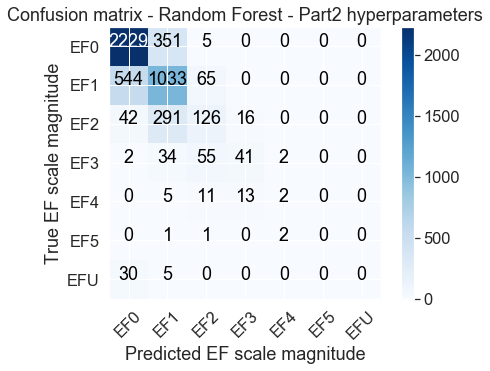

In [61]:
# Computing the confusion matrix
confmatrix_rf2 = confusion_matrix(ytest1, rf2.predict(Xtest1))

# Plotting it using the function:
sns.set(font_scale=1.5)
plt.figure(figsize=(7,5))
plot_confusion_matrix(confmatrix_rf2, rf2.classes_,
                      'Confusion matrix - Random Forest - Part2 hyperparameters',
                      xlab='Predicted EF scale magnitude', ylab='True EF scale magnitude')
plt.show()

In [62]:
params_randfor_v1 = {'criterion': ['gini','entropy'],
                     'max_depth': [10,15],
                     'max_features': [0.4,0.6,0.8],
                     'n_estimators': [20, 40, 60, 80],
                     'min_samples_split': [6, 10, 14],
                     'min_samples_leaf': [1,2]
                    }

rf3 = GridSearchCV(rf1, param_grid=params_randfor_v1, cv=5, verbose=1, n_jobs=2)
rf3.fit(Xtrain1, ytrain1)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   27.7s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  2.1min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  5.8min
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed: 12.5min
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed: 21.4min
[Parallel(n_jobs=2)]: Done 1440 out of 1440 | elapsed: 26.8min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=2,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [10, 15], 'max_features': [0.4, 0.6, 0.8], 'n_estimators': [20, 40, 60, 80], 'min_samples_split': [6, 10, 14], 'min_samples_leaf': [1, 2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [63]:
rf3.best_params_

{'criterion': 'entropy',
 'max_depth': 15,
 'max_features': 0.8,
 'min_samples_leaf': 1,
 'min_samples_split': 6,
 'n_estimators': 60}

In [64]:
print("Accuracy | Train CV5\t | Random Forest\t | Optimal params:\t", round(rf3.best_score_, 3))

Accuracy | Train CV5	 | Random Forest	 | Optimal params:	 0.701


In [65]:
rf4 = rf3.best_estimator_
rf4.fit(Xtrain1, ytrain1)

yhat1_rf4 = rf4.predict(Xtest1)
accuracy_rf4 = accuracy_score(ytest1, yhat1_rf4)
print("Accuracy | Test\t\t | Random Forest\t | Optimized params:\t", round(accuracy_rf4, 3))

Accuracy | Test		 | Random Forest	 | Optimized params:	 0.703


In [66]:
params_randfor_v2 = {'criterion': ['entropy'],
                     'max_depth': [16,18,20],
                     'max_features': [0.3,0.4,0.5],
                     'n_estimators': [68,70,72],
                     'min_samples_split': [8,9,10],
                     'min_samples_leaf': [1]
                    }

rf5 = GridSearchCV(rf1, param_grid=params_randfor_v2, cv=5, verbose=1, n_jobs=2)
rf5.fit(Xtrain1, ytrain1)

print("\nBest params:", rf5.best_params_)

print("\nAccuracy | Train CV5\t | Random Forest\t | Optimal params:\t", round(rf5.best_score_, 3))

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   49.8s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  4.8min
[Parallel(n_jobs=2)]: Done 405 out of 405 | elapsed:  9.9min finished



Best params: {'criterion': 'entropy', 'max_depth': 18, 'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 9, 'n_estimators': 70}

Accuracy | Train CV5	 | Random Forest	 | Optimal params:	 0.701


In [67]:
# First time use after gridsearch: rf6 = rf5.best_estimator_
# Not to have to rerun the gridsearch again:
rf6 = RandomForestClassifier(criterion='entropy', max_depth=18, max_features=0.4, 
                             min_samples_leaf=1, min_samples_split=9, 
                             n_estimators=72, random_state=31)
rf6.fit(Xtrain1, ytrain1)

yhat1_rf6 = rf6.predict(Xtest1)
accuracy_rf6 = accuracy_score(ytest1, yhat1_rf6)
print("Accuracy | Test\t\t | Random Forest\t | Optimized params:\t", round(accuracy_rf6, 3))

Accuracy | Test		 | Random Forest	 | Optimized params:	 0.706


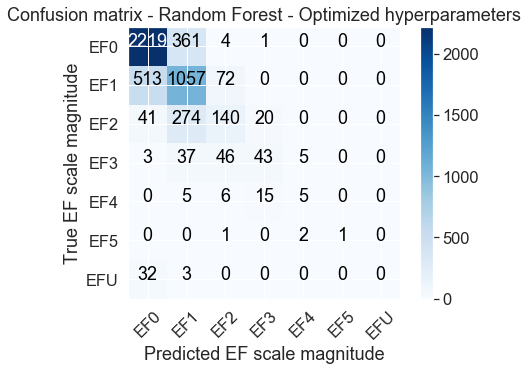

In [68]:
# Computing the confusion matrix
confmatrix_rf6 = confusion_matrix(ytest1, rf6.predict(Xtest1))

# Plotting it using the function:
sns.set(font_scale=1.5)
plt.figure(figsize=(7,5))
plot_confusion_matrix(confmatrix_rf6, rf6.classes_,
                      'Confusion matrix - Random Forest - Optimized hyperparameters',
                      xlab='Predicted EF scale magnitude', ylab='True EF scale magnitude')
plt.show()

In [69]:
# Creating a DF out of the coefficients, and sorting them in order of importance of 
# their absolute value:
importanceDF_rf6 = pd.DataFrame({'Importances': rf6.feature_importances_},
                          index = Xtrain1.columns)
importanceDF_rf6.T

TOR_LENGTH  TOR_WIDTH  Duration  AverageDate  AverageTime  \
Importances    0.151527   0.240328  0.070915     0.060825     0.071346   

               Deaths  Injuries  Mean_Lat  Mean_Lon   Azimuth  \
Importances  0.015278   0.05557  0.076984  0.096865  0.065869   

                      ...            Source_Official_NWS_Observations  \
Importances           ...                                    0.000017   

             Source_Other_Federal_Agency  Source_Park/Forest_Service  \
Importances                     0.001288                    0.000403   

             Source_Public  Source_Social_Media  Source_State_Official  \
Importances       0.002201             0.000007               0.000022   

             Source_Storm_Chaser  Source_Trained_Spotter  Source_Unknown  \
Importances             0.013941                0.006561             0.0   

             Source_Utility_Company  
Importances                0.000082  

[1 rows x 86 columns]

In [70]:
# Most important features:
mostimp_rf6 = importanceDF_rf6.sort_values(by="Importances", ascending=False)
mostimp_rf6.head(3)

Importances
TOR_WIDTH      0.240328
TOR_LENGTH     0.151527
Mean_Lon       0.096865

In [80]:
# Horizontal bar plot


Neural Network 

In [82]:
X2 = X1numfeat.copy()
print(X2.shape)

(16353, 10)


In [83]:
Xtrain2, Xtest2, ytrain2, ytest2 = train_test_split(X2, y1, test_size=0.3, 
                                                    stratify=y1, random_state=31)

In [85]:
# Same parameters as the best one we obtained:
lr4 = LogisticRegression(penalty='l2', C=1000000)
accuracy_cv5_lr4 = np.mean(cross_val_score(lr4, Xtrain2, ytrain2, cv=5))
print ("Accuracy | Train CV5\t | Logistic Regresssion\t | Default params\t | No dummies:\t"), round(accuracy_cv5_lr4, 3)

Accuracy | Train CV5	 | Logistic Regresssion	 | Default params	 | No dummies:	


(None, 0.641)

In [86]:

lr4.fit(Xtrain2, ytrain2)
yhat2_lr4 = lr4.predict(Xtest2)
accuracy_lr4 = accuracy_score(ytest2, yhat2_lr4)
print ("Accuracy | Test\t\t | Logistic Regresssion\t | Default params\t | No dummies:\t"), round(accuracy_lr4, 3)

Accuracy | Test		 | Logistic Regresssion	 | Default params	 | No dummies:	


(None, 0.638)

In [87]:
# Same parameters as the best one we obtained:
rf7 = RandomForestClassifier(criterion='entropy', max_depth=18, max_features=0.4, 
                             min_samples_leaf=1, min_samples_split=9,
                             n_estimators=72, random_state=31)
accuracy_cv5_rf7 = np.mean(cross_val_score(rf7, Xtrain2, ytrain2, cv=5))
print ("Accuracy | Train CV5\t | Random Forest\t | Default params\t | No dummies:\t"), round(accuracy_cv5_rf7, 3)

Accuracy | Train CV5	 | Random Forest	 | Default params	 | No dummies:	


(None, 0.692)

In [88]:
rf7.fit(Xtrain2, ytrain2)
yhat2_rf7 = rf7.predict(Xtest2)
accuracy_rf7 = accuracy_score(ytest2, yhat2_rf7)
print ("Accuracy | Test\t\t | Random Forest\t | Default params\t | No dummies:\t"), round(accuracy_rf7, 3)

Accuracy | Test		 | Random Forest	 | Default params	 | No dummies:	


(None, 0.706)

In [95]:
#X2.reset_index(drop=True, inplace=True)
np.random.seed(7)
# create model
model = Sequential()
model.add(Dense(10, input_dim=10, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [96]:
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [97]:
model.fit(np.array(Xtrain2),
          np.array(ytrain2.map(convertEFtonb)),
          epochs=150, batch_size=10)

Instructions for updating:
Use tf.cast instead.
Epoch 1/150
11447/11447 [==============================] - 1s 128us/step - loss: -0.5566 - acc: 0.5661
Epoch 2/150
11447/11447 [==============================] - 1s 93us/step - loss: -1.3393 - acc: 0.6510
Epoch 3/150
11447/11447 [==============================] - 1s 93us/step - loss: -1.4472 - acc: 0.6603
Epoch 4/150
11447/11447 [==============================] - 1s 94us/step - loss: -1.4842 - acc: 0.6645
Epoch 5/150
11447/11447 [==============================] - 1s 94us/step - loss: -1.5078 - acc: 0.6645
Epoch 6/150
11447/11447 [==============================] - 1s 94us/step - loss: -1.5236 - acc: 0.6643
Epoch 7/150
11447/11447 [==============================] - 1s 93us/step - loss: -1.5403 - acc: 0.6665
Epoch 8/150
11447/11447 [==============================] - 1s 93us/step - loss: -1.5529 - acc: 0.6679
Epoch 9/150
11447/11447 [==============================] - 1s 93us/step - loss: -1.5618 - acc: 0.6673
Epoch 10/150
11447/11447 [=======

Epoch 78/150
11447/11447 [==============================] - 1s 106us/step - loss: -1.6941 - acc: 0.6691
Epoch 79/150
11447/11447 [==============================] - 1s 108us/step - loss: -1.6978 - acc: 0.6676
Epoch 80/150
11447/11447 [==============================] - 1s 120us/step - loss: -1.6958 - acc: 0.6700
Epoch 81/150
11447/11447 [==============================] - 1s 109us/step - loss: -1.6978 - acc: 0.6693
Epoch 82/150
11447/11447 [==============================] - 1s 117us/step - loss: -1.6976 - acc: 0.6664
Epoch 83/150
11447/11447 [==============================] - 1s 102us/step - loss: -1.6965 - acc: 0.6679
Epoch 84/150
11447/11447 [==============================] - 1s 93us/step - loss: -1.6991 - acc: 0.6688
Epoch 85/150
11447/11447 [==============================] - 1s 93us/step - loss: -1.6998 - acc: 0.6686
Epoch 86/150
11447/11447 [==============================] - 1s 93us/step - loss: -1.6974 - acc: 0.6713
Epoch 87/150
11447/11447 [==============================] - 1s 93us

In [98]:
# Predictions on the test set:
yhat2_rnn1 = model.predict(np.array(Xtest2))
len(yhat2_rnn1)

4906

In [99]:
ytest2array = np.array(ytest2.map(convertEFtonb))
ytest2array.shape

(4906,)

In [104]:
yhat2_rnn1trans = np.empty_like(ytest2array)
for i in range(len(yhat2_rnn1)):
    yhat2_rnn1trans[i] = int(round(float(yhat2_rnn1[i])))

yhat2_rnn1trans.shape

(4906,)

In [106]:
accuracy_rnn1 = accuracy_score(ytest2array, yhat2_rnn1trans)
print ("Accuracy | Test\t\t | Logistic Regresssion\t\t | Default params\t | No dummies:\t"), round(accuracy_lr1, 3)
print ("Accuracy | Test\t\t | Random Forest\t\t | Default params\t | No dummies:\t"), round(accuracy_rf7, 3)
print ("Accuracy | Test\t\t | Recursive Neural Network\t | Test params:\t\t\t"), round(accuracy_rnn1, 3)

Accuracy | Test		 | Logistic Regresssion		 | Default params	 | No dummies:	
Accuracy | Test		 | Random Forest		 | Default params	 | No dummies:	
Accuracy | Test		 | Recursive Neural Network	 | Test params:			


(None, 0.669)